In [4]:

def is_square_free( f ) :
    """
    This function checks if the polynomial `f` is square-free.
    """
    return gcd( f, f.derivative() ) == 1
        
def rad( f ) :
    """
    This function computes the radical of `f`.
    """
    # find the ring of polynomials
    P = f.parent()
    # return the radical
    return P(f/gcd(f,f.derivative()))
    
def square_free_decomposition( f ) :
    """
    This function takes a polynomial `f` and returns its square-free \
    decomposition computed using Tobey-Horowitz algorithm.
    The additional parameter omit_trivial_factors constrols whether factors = 1 \
    should be omitted (default) or not.
    """
    # The base ring must be a field of characteristic zero
    assert f.base_ring().characteristic() == 0, "The characteristic must be zero!"
    assert f.base_ring().is_field(), "The base ring must be a field!"

    lcf = f.leading_coefficient()
    G = list(f.monic().squarefree_decomposition())
    return Factorization( G, unit = lcf, sort = false )
    
def depress( f ) :
    """
    This function computes the depressed form of a given polynomial `f`.
    """
    # take the leading coefficient
    lcf = f.leading_coefficient()
    # normalize f
    f /= lcf
    # the degree of f
    n = f.degree()
    # depress f
    g = f( x-f[n-1]/n )
    return g
    
def Cauchy_1( f ) :
    """
    Given a polynomial `f`, this function computes `M` s.t. all the roots of `f` are contained in `(-M,M)`.
    It uses the "first" Cauchy bound.
    """
    n = f.degree()
    return 1 + max([abs(f[j]/f[n]) for j in [0..n-1]])
    
def Cauchy_2( f ) :
    """
    Given a polynomial `f`, this function computes `M` s.t. all the roots of `f` are contained in `(-M,M)`.
    It uses the "second" Cauchy bound.
    """
    n = f.degree()
    return max( (n*abs(f[n-j]/f[n]))^(1/j) for j in [1..n] )
    
def Hong( f ) :
    """
    Given a polynomial `f`, thsi function computes `M > 0` s.t. all the REAL roots of `f` are contained in `(-M,M)`.
    It uses Hong's theorem.
    """
    if f.leading_coefficient() < 0 :
        f = -f
    n = f.degree()
    H = max( min( (-f[j]/f[i])^(1/(i-j)) for i in [j+1..n] if f[i] > 0 ) for j in [0..n-1] if f[j] < 0 )
    return 2*H
    
def local_max( f ) :
    """
    Given a polynomial `f`, thsi function computes `M > 0` s.t. all the REAL roots of `f` are contained in `(-M,M)`.
    It uses local-max algorithm.
    """
    n = f.degree()
    M = 0
    t = 1
    i_max = n
    for j in [n-1,n-2,..0] :
        if f[j] > f[i_max] :
            i_max = j
            t = 1
        if f[j] < 0 :
            m = ( -2^t*f[j]/f[i_max] )^( 1/(i_max - j) )
            t = t+1
            M = max(m, M)
    return M

def Sturm_sequence( f ) :
    """
    Given a polynomial `f` this function returns its Sturm sequence.
    """
    # g_0 is just f, while g_1 is the derivative of f
    g = f.derivative()
    # append both to the list
    G = [ f, g ]
    # repeat till yu hit a constant
    while not g.is_constant() :
        # substitute f by g and g by the minus reminder...
        f, g = g, -f.mod(g)
        # ...and append it to the list
        G.append(g)
    return G

def sign_changes( L ) :
    """
    This function counts the number sign changes in `L`
    """
    # remove all zeros and substitute each element by its signature
    L = [ sgn(a) for a in L if a != 0 ]
    # leave only those element that differs from it predecessors
    S = [ L[j] for j in range(1, len(L)) if L[j] != L[j-1] ]
    # the number of sign changes in $L$ equals the length of $S$
    return len(S)

def count_roots( f, a= -oo, b = oo, S = [] ) :
    """
    This function counts the number of roots of `f` in the interval `(a,b)`.
    
    The optional parameter `S` is the Sturm sequence of `f`, if it has already been computed.
    """
    assert a < b, "Improper interval!"
    
    # if we don't have the Sturm sequence, then we must compute it
    if S == [] :
        S = Sturm_sequence( f )
    # substitute the endpoint of the interval to the Sturm sequence
    Sa = [ g(a) for g in S[:-1] ] + [S[-1]]
    Sb = [ g(b) for g in S[:-1] ] + [S[-1]]
    # return the difference of the numbers of sign changes
    return sign_changes(Sa) - sign_changes(Sb)

def root_isolation( f, a, b, S = [] ) :
    """
    This function takes the following arguments:
        
       - a polynomial `f`
       
       - an interval `(a,b)`
       
       - (optionally) the Sturm sequence of `f`
       
    as a result it return a list of pairs `( (a_j,b_j) : j ∊ {1,...,n} )` such that:
        
       - `f(a_j) = 0` iff `a_j = b_j`
       
       - `f` has precisely one root `x_j` s.t. `a_j < x_j < b_j`
       
       - `f'`, `f"` have not roots in `(a_j, b_j)` for every `j`
       
    """
    assert a < b, "Improper interval!"

    # if a is infinite, then substitute it by a bound
    if a == -oo :
        a = -RDF( local_max(f) )
    # if b is infinite, then substitute it by a bound
    if b == oo :
        b = RDF( local_max(f) )
        
    # the variable of our polynomial
    x = f.parent().0

    # if any of the endpoints is a root of f, then append it to the list
    # and narrow the interval
    if f(a) == 0 :
        epsilon = RDF( 1/local_max(f(x+a).list()[::-1]) )
        return [(a,a)] + root_isolation(f, (a+epsilon,b), S)
    if f(b) == 0 :
        epsilon = RDF( 1/local_max(f(x+b).list()[::-1]) )
        return root_isolation(f, (a,b-epsilon), S) + [(b,b)]
        
    # compute the Sturm sequence if it is not provided
    if S == [] :
        S = Sturm_sequence( f )
    # count the number of root of f in (a,b)
    p = count_roots(f, (a,b), S )
    # if f has no roots, then return an empty list
    if p == 0 :
        return []

    # if `f` has just one root, then count the number of roots of its derivatives
    if p == 1 :
        fp = f.derivative()
        fpp = f.derivative(2)
        pp = count_roots(fp, (a,b))
        ppp = count_roots(fpp, (a,b))
        # if they bot do not have roots, then we are done
        if pp == 0 and ppp == 0 :
            return [(a,b)]
            
    # otherwise bisect the interval and call the function recursively for each half
    c = (a+b)/2
    # this "if" protects us again c being counted twice
    if f(c) != 0 :
        L = root_isolation(f, (a,c), S)
        U = root_isolation(f, (c,b), S)
        return L + U
    else :
        epsilon = RDF(1/local_max(f(x-c).list()[::-1]))
        return root_isolation(f, (a,c-epsilon), S) + [(c,c)] + root_isolation(f, (c+epsilon,b), S)
        
def rational_roots( f ) :
    """
    This function computes all the rational roots of a given polynomial `f`
    with rational coefficients.
    """
    assert f.base_ring() <= QQ, "The ring of ceofficients must be contained in QQ."

    # find the radical of f
    fs = rad(f)
    # find the common denominator of the coefficients
    M = lcm([fi.denominator() for fi in fs])
    # ring of polys with integer coeffs
    P = ZZ[f.parent().0]
    # convert f to a polynomial with integer coefficients
    fz = P(M*fs)
    # find the primitive part
    fz = P( fz/gcd(list(fz)) )
    
    # if zero is a root of $f$...
    if fz(0) == 0 :
        # ...then append zero to the list of roots...
        C = [0]
        # ...and divide $f$ by $x$
        # the following line just reads fz = fz/x, but
        # is safely independent of the actual name of the variable
        fz = P(fz/P.0)
    else:
        # otherwise we begin with an empty list of roots
        C = []
    # find the divizors of the constant term
    A = fz[0].divisors()
    # find the divisors of the leading coefficient
    B = fz.leading_coefficient().divisors()
    # check all the quotients...
    C += [ a/b for a in A for b in B if f(a/b) == 0 ]
    # ...don't forget about the negative ones
    C += [ -a/b for a in A for b in B if f(-a/b) == 0 ]
    # return the result
    return uniq(C)

<p><span style="color: #ff0000;"><strong>The (hidden) cell above will execute automatically upon loading this worksheet. It contains the following functions from the previous set:</strong></span></p>
<ul>
<li><span style="font-family: courier new,courier; color: #ff0000;">is_square_free(f), <br /></span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">rad( f ), <br /></span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">square_free_decomposition( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">rational_roots( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">depress( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">Cauchy_1( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">Cauchy_2( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">Hong( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">local_max( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">Sturm_sequence( f )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">sign_changes( L )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">count_roots( f, (a, b) = (-oo,oo), S = [] )</span></li>
<li><span style="font-family: courier new,courier; color: #ff0000;">root_isolation( f, (a,b), S = [] )</span></li>
</ul>
<h2>Root approximation</h2>
<p><strong>Exercise:</strong> Let $f=x^{5} - 5 x^{3} + 4 x - 1$ and $a = 1.75$, $b = 2.25$.</p>
<ol>
<li>Check that $f$ has exactly one root between $a$ and $b$.</li>
<li>Check that $f'$, $f"$ do not have roots in $(a,b)$.</li>
<li>Plot the graph of $f$ on this interval.</li>
<li>Approximate the (unique) root of $f$ in $(a,b)$ with accuracy $10^{-3}$. Do it step by step</li>
<li>Superimpose the obtained secant on the graph of $f$</li>
</ol>

In [7]:
# define a polynomial f...
P.<x> = QQ[]
f = x^5-5*x^3+4*x-1; show(f)
# ...the endpoints...
a = 1.75
b = 2.15
# ...and the accuracy
epsilon = 10^-3

x^5 - 5*x^3 + 4*x - 1

In [8]:
# check that f has exactly one root in (a,b)
count_roots( f, a, b) 

1

In [9]:
# check that f' has no roots in (a,b)
count_roots( f.derivative(), a, b) 

0

In [10]:
# check that f" has no roots in (a,b)
count_roots( f.derivative(2), a, b) 

0

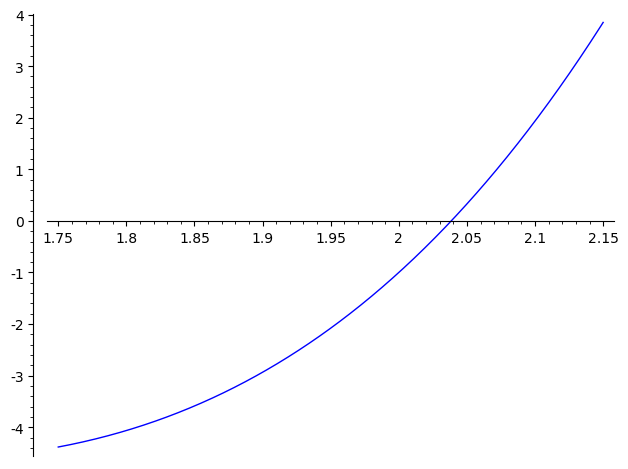

In [11]:
# plot the graph of f on (a,b)
rys = f.plot(a, b); show(rys)

In [93]:
# initialization of R-F: z is the right enpoint and x_0 is the left one
z = b
x0 = a; view(x0)
# let X be the lists of successive approximations
# first it contains just x_0
X = [x0]

In [94]:
# compute the next approximation
x1 = x0 - (z-x0)/(f(z) - f(x0))*f(x0); view(x1)
# ...append it to the list X...
X.append(x1)
# check if the distance |x_0 - x_1| < \varepsilon
abs(x0-x1) < epsilon


False

In [95]:
# repeat...
x2 = x1 - (z-x1)/(f(z) - f(x1))*f(x1); view(x2)
X.append(x2)
abs(x1-x2) < epsilon


False

In [96]:
# ...again...
x3 = x2 - (z-x2)/(f(z) - f(x2))*f(x2); view(x3)
X.append(x3)
abs(x2-x3) < epsilon


False

In [97]:
# ...and again...
x4 = x3 - (z-x3)/(f(z) - f(x3))*f(x3); view(x4)
X.append(x4)
abs(x3-x4) < epsilon


False

In [98]:
# ...and again...
x5 = x4 - (z-x4)/(f(z) - f(x4))*f(x4); view(x5)
X.append(x5)
abs(x4-x5) < epsilon


True

In [99]:
# superimpose the chords from (z,f(z)) to (x_j,f(x_j)) onto the plot
rys += sum([ line([(z,f(z)),(xx,f(xx))], color='gray') for xx in X ]) + sum([ line2d([(X[j],0), (X[j],f(X[j]))], color='gray', linestyle='--') for j in range(1,len(X))])
show(rys)

<p><strong>Exercise:</strong> Write a function that a root of $f$ in the interval $(a,b)$ using <em>regula-falsi</em> algorithm.</p>

In [114]:
def regula_falsi( f, (a,b), epsilon = 10^-3 ) :
    """
    The function takes the following arguments: 
        
      - a polynomial `f`
      
      - a real interval `(a,b)` s.t. `f` has exactly one root \
        and `f', f"` have constant signs
        
      - optionally an accuracy `\\varepsilon` (by default `\\varepsilon = 10^{-3}`)
      
    This function return  `x\\in (a,b)` s.t. there is a root \
    `\\xi` of `f` and `|x - \\xi| < \\\varepsilon`.
    """
    # check that a < b
    assert a < b, "Improper interval!"
    # check that f has precisely one root in (a,b)
    assert count_roots(f, (a,b)) == 1, 'f must have a single root in (a,b)!'
    # check that neither f' nor f" has a root in (a,b)
    assert count_roots(f.derivative(), (a,b)) == 0, 'f\' cannot have a root in (a,b)'
    assert count_roots(f.derivative(2), (a,b)) == 0, 'f\" cannot have a root in (a,b)'

    # take the midpoint to check which of the cases (i)-(iv) we are dealing with
    c = (a+b)/2
    fp = f.derivative()
    fpp = f.derivative(2)
    if sgn(fp(c)) == sgn(fpp(c)) :
        # cases (i), (iii)
        z = b
        x0 = a
    else:
        # cases (ii), (iv)
        z = a
        x0 = b
    # compute x_1
    x1 = x0 - (z-x0)/(f(z) - f(x0))*f(x0)
    # repeat as long as f(x_0-\varepsilon) f(x_0+\varepsilon) > 0
    while f(x0-epsilon)*f(x0+epsilon) > 0 :
        x0 = x0 - (z-x0)/(f(z) - f(x0))*f(x0)
    return x0

In [115]:
# check with the previous example
x0 = regula_falsi(x^5-5*x^3+4*x-1, (1.75, 2.15), 10^-10); print x0
print abs(f(x0))

2.03849529100513
8.85352791080152e-10

<p><strong>Exercise:</strong> Find all the real roots of $f=x^{5} - 5 x^{3} + 4 x - 1$.</p>
<p>1) Define $f$ and check if it is square-free.</p>

In [102]:
# define a polynomial f
f = x^5-5*x^3+4*x-1; view("f = " + latex(f))
# check
is_square_free( f )


True

<p>2) Find the intervals isolating the real roots of $f$.</p>

In [103]:
# isolate the roots f
A = root_isolation(f, (-oo,oo)); A

[(-1.9764235376052373, -1.7787811838447136),
 (-1.1858541225631423, -0.7905694150420949),
 (0.0, 0.39528470752104744),
 (0.7905694150420949, 1.1858541225631423),
 (1.9764235376052373, 2.3717082451262845)]

<p>3) In each interval, approximate the corresponding root of $f$ up to $10$ decimal digits</p>

In [104]:
j = 0
for (a,b) in A :
    xx = regula_falsi(f, (a,b), 10^-10)
    view("x_" + latex(j) + " = " + latex(xx))
    j += 1

<p><strong>Exercise:</strong> Find all the real roots of $f = x^{8} - 6 x^{7} + 12 x^{6} - 8 x^{5} - x^{4} + 7 x^{3} - 18 x^{2} + 20 x - 8$.</p>
<p>1) Define $f$ and check that it is NOT square-free.</p>

In [105]:
# define a polynomial f
f = x^8 - 6*x^7 + 12*x^6 - 8*x^5 - x^4 + 7*x^3 - 18*x^2 + 20*x - 8 
view("f = " + latex(f))
# check
is_square_free( f )


False

<p>2) Find the square-free factors of $f$.</p>

In [106]:
G = square_free_decomposition(f); view(list(G))

<p>3) Isolate and approximate the roots of every non-constant factor.</p>

In [107]:
j = 0
for (g,k) in G :
    if g in  QQ :
        continue
    A = root_isolation(g, (-oo,oo))
    for (a,b) in A :
        if a < b :
            xx = regula_falsi(g, (a,b), 10^-10)
        else :
            xx = a
        view("x_" + latex(j) + " = " + latex(xx))
        j += 1

<p><strong>Exercise:</strong> Write a function, that finds all the real roots of a given polynomial.</p>

In [108]:
def real_roots( f, epsilon = 10^-3 ) :
    """
    Given a polynomial `f`, this functions returns all the real roots of `f` \
    (either exact or approximated with accuracy `\\varepsilon`)
    """
    # the ring of polynomials containing f
    P = f.parent()
    
    # find the square-free factorization of f
    G = square_free_decomposition(f)
    X = []
    # loop over the square-free factors of f
    for (g,k) in G :
        # omit the constant terms
        if g in f.base_ring() :
            continue
        # first find (exact) rational roots
        W = rational_roots(g)
        # and append them to the list of roots
        X += [ (xx,k) for xx in W ]
        # factor them out by little Bezout theorem
        h = prod(P.0-xx for xx in W)
        # if all the roots are rational, then finish with g 
        if P(h).degree() == g.degree() :
            continue
        g = P(g/h)
        
        # isolate the remaining roots
        A = root_isolation(g, (-oo,oo))
        # loop over the isolating intervals
        for (a,b) in A :
            if a < b :
                # approximate the (unique) root
                xx = regula_falsi(g, (a,b), 10^-10)
                # and append it to the list (the multiplicity of the 
                # root is the exponent of the square-free factor)
                X.append((xx,k))
            else :
                # special case, when a=b is an exact root
                X.append((a,k))
                
    return X

In [109]:
# check it
real_roots( x^5-5*x^3+4*x-1 )

__main__:245: DeprecationWarning: the output of uniq(X) being sorted is deprecated; use sorted(set(X)) instead if you want sorted output
See https://trac.sagemath.org/27014 for details.
[(-1.9540796146143022, 1),
 (-1.150984173228422, 1),
 (0.2758341933539541, 1),
 (0.7907343034776252, 1),
 (2.038495290987126, 1)]

<p><strong>Exercise:</strong> Write a function that approximates a root of $f$ in the interval $(a,b)$ with the secant method.</p>

In [124]:
def secant_method( f, (a,b), epsilon = 10^-3 ) :
    """
    The function takes the following arguments: 
        
      - a polynomial `f`
      
      - a real interval `(a,b)` s.t. `f` has exactly one root and `f', f"` have constant signs
      
      - optionally an accuracy `\\varepsilon` (by default `\\varepsilon = 10^{-3}`)
      
    This function return  `x\\in (a,b)` s.t. there is a root \
    `\\xi` of `f` and `|x - \\xi| < \\varepsilon`.
    """
    # check that a < b
    assert a < b, "Improper interval!"
    # check that f has precisely one root in (a,b)
    assert count_roots(f, (a,b)) == 1, 'f must have a single root in (a,b)!'
    # check that neither f' nor f" has a root in (a,b)
    assert count_roots(f.derivative(), (a,b)) == 0, 'f\' cannot have a root in (a,b)'
    assert count_roots(f.derivative(2), (a,b)) == 0, 'f\" cannot have a root in (a,b)'

    # take the midpoint to check which of the cases (i)-(iv) we are dealing with
    c = (a+b)/2
    fp = f.derivative()
    fpp = f.derivative(2)
    if sgn(fp(c)) == sgn(fpp(c)) :
        # cases (i), (iii)
        z = b
        x0 = a
    else:
        # cases (ii), (iv)
        z = a
        x0 = b
    # compute x_1
    x1 = x0 - (z-x0)/(f(z) - f(x0))*f(x0)
    # reapeat as long as |x_0 - x_1| > \varepsilon
    while abs(x0-x1) > epsilon :
        # the only change to R-F is here:
        x0, x1 = x1, x0 - (x1-x0)/(f(x1) - f(x0))*f(x0)
        # verify against an divergent sequence
        if abs(x0-x1) > abs(a-b) :
            return false
    return x1

In [126]:
# check with the previous example
f = x^5-5*x^3+4*x-1; view("f = " + latex(f))
a = 1.75
b = 2.15
xx = secant_method(f, (a,b), 10^-15); print xx
print f(xx)


2.03849529103674
-6.66133814775094e-16

<p><span id="cell_outer_111"><strong>Exercise:</strong> Write a function that approximates a root of a given polynomial $f$ in the interval $(a,b)$ using Newton-Raphson algorithm.</span></p>

In [127]:
def Newton_method( f, x0, (a,b), epsilon = 10^-3 ) :
    """
    The function takes the following arguments: 
        
      - a polynomial `f`
      
      - an initial guess `x_0`
      
      - a real interval `(a,b)` s.t. `f` has exactly one root \
        and `f', f"` have constant signs
        
      - optionally an accuracy `\\varepsilon` (by default `\\varepsilon = 10^{-3}`)
      
    This function return  `x\\in (a,b)` s.t. there is a root `\\xi` of `f` \
    and `|x - \\xi| < \\varepsilon`.
    """
    # check that a < b
    assert a < b, "Improper interval!"
    # check that f has precisely one root in (a,b)
    assert count_roots(f, (a,b)) == 1, 'f must have a single root in (a,b)!'
    # check that neither f' nor f" has a root in (a,b)
    assert count_roots(f.derivative(), (a,b)) == 0, 'f\' cannot have a root in (a,b)'
    assert count_roots(f.derivative(2), (a,b)) == 0, 'f\" cannot have a root in (a,b)'

    fp = f.derivative()
    fpp = f.derivative(2)
    # compute x_1 (this line has changed)
    x1 = x0 - f(x0)/fp(x0)
    # repeat as long as |x_0 - x_1| > \varepsilon
    while abs(x0-x1) > epsilon :
        x0 = x1
        # here comes a change
        x1 = x0 - f(x0)/fp(x0)
        # verify against a divergent sequence
        if abs(x0-x1) > abs(a-b) :
            return false
    return x1

In [129]:
# check with the previous example
f = x^5-5*x^3+4*x-1; view("f = " + latex(f))
a = 1.75
b = 2.15
xx = Newton_method(f, 0.5*(a+b), (a,b), 10^-15); print xx
print f(xx)


2.03849529103674
-6.66133814775094e-16

<p><span><strong>Exercise:</strong> Write a function that approximates a root of a given polynomial $f$ using Laguerre's algorithm.</span></p>

In [171]:
def Laguerre_method( f, x0, epsilon = 10^-3 ) :
    """
    The function takes the following arguments: 
        
      - a polynomial `f`
      
      - an initial guess `x_0`
      
      - optionally an accuracy `\\varepsilon` (by default `\\varepsilon = 10^{-3}`)
      
    This function return  `x\\in \\mathbb{C}` s.t. there is a root `\\xi` of `f` \
    and `|x - \\xi| < \\varepsilon`.
    """

    # distance between two successive approximations (take 1 to begin with)
    d = 1
    # store f', f"...
    fp = f.derivative()
    fpp = fp.derivative()
    # ...and the degree of f
    n = f.degree()
    # the main loop
    while abs(d) > epsilon :
        # Laguerre's formula
        fx   = f(x0)  
        fpx  = fp(x0)
        fppx = fpp(x0)
        g = fpx/fx
        h = g^2 - fppx/fx
        s = sqrt( (n-1)*(n*h-g^2) )
        v = g + s
        if real_part( conjugate(g)*s ) < 0 :
            v = g - 2*s
        d = n/v
        x0 -= d
    # return the result
    return x0

In [172]:
# check with the previous example
f = x^5-5*x^3+4*x-1; view("f = " + latex(f))
a = 1.75
b = 2.15
xx = Laguerre_method(f, 0.5*(a+b), 10^-15); print xx
print f(xx)


2.03849529103674
-1.89848137210902e-14